# Work zone detection: YOLO training and evaluation

## 1. Notebook goals

In this notebook we will:

1. Install and load Ultralytics YOLO.
2. Train a real time work zone detector on the ROADWork to YOLO dataset.
3. Inspect training logs and curves.
4. Run evaluation on the validation split and check mAP.
5. Measure approximate inference speed (FPS) on a sample resolution.

This will give us a first baseline detector for work zone objects that we can later use in a video demo app.


In [ ]:
# %% Imports and environment check

import os
from pathlib import Path
import time

import torch

ROOT = Path(".").resolve()
YOLO_ROOT = ROOT / "workzone_yolo"
DATA_YAML = YOLO_ROOT / "workzone_yolo.yaml"

print("Root:", ROOT)
print("YOLO dataset exists:", YOLO_ROOT.exists())
print("Data YAML exists:", DATA_YAML.exists())

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

Root: /home/wesley/code/workzone
YOLO dataset exists: True
Data YAML exists: True
PyTorch version: 2.9.1+cu128
CUDA available: False


## 2. Install Ultralytics YOLO

We install the `ultralytics` package and import the `YOLO` class.  
This interface allows us to train and evaluate YOLO models directly from the notebook.

In [2]:
# %% Install Ultralytics (run once)

from ultralytics import YOLO

## 3. Choose model and training hyperparameters

We will start with a small detector that is suitable for real time use.

Suggested configuration:

- Base model: `yolov8s.pt` (small model, good balance of speed and accuracy)
- Image size: 640
- Batch size: 16 (adjust if you hit out of memory)
- Epochs: 50 (we can adjust later)
- Data: `workzone_yolo.yaml` from Notebook 1

You can later experiment with `yolov8n.pt` for faster inference or `yolov8m.pt` for more accuracy.

In [ ]:
# %% Load base model

model = YOLO("yolo12s.pt")  # or "yolov8n.pt" for nano

# %% Train the model

results = model.train(
    data=str(DATA_YAML),
    imgsz=640,
    epochs=100,
    batch=4,
    project="runs_workzone",
    name="yolo12s_workzone",
    exist_ok=True,
)

New https://pypi.org/project/ultralytics/8.3.234 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.232 🚀 Python-3.12.3 torch-2.9.1+cu128 CPU (AMD Ryzen AI 9 HX 370 w/ Radeon 890M)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/wesley/code/workzone/workzone_yolo/workzone_yolo.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals

RuntimeError: Dataset '/home/wesley/code/workzone/workzone_yolo/workzone_yolo.yaml' error ❌ Dataset '/home/wesley/code/workzone/workzone_yolo/workzone_yolo.yaml' images not found, missing path '/home/wesley/code/workzone/datasets/C:\Users\wesle\Music\workingzone\workzone_yolo/images/val'
Note dataset download directory is '/home/wesley/code/workzone/datasets'. You can update this in '/home/wesley/.config/Ultralytics/settings.json'

## 4. Inspect training artifacts

After training, YOLO saves:

- `runs_workzone/detect/yolov8s_workzone/weights/best.pt`  trained weights
- `results.png`  training and validation curves
- `confusion_matrix.png` and `confusion_matrix_normalized.png`
- `labels_correlogram.png`

We can load and display these images in the notebook.

In [10]:
# %% Locate run folder and list contents

run_dir = Path("runs_workzone") / "yolov8s_workzone"  # no "detect" here
print("Run directory:", run_dir.resolve())
print("Exists:", run_dir.exists())
print("Contents:")
for p in sorted(run_dir.iterdir()):
    print(" ", p.name)

Run directory: C:\Users\wesle\Music\workingzone\runs_workzone\yolov8s_workzone
Exists: True
Contents:
  args.yaml
  BoxF1_curve.png
  BoxP_curve.png
  BoxPR_curve.png
  BoxR_curve.png
  confusion_matrix.png
  confusion_matrix_normalized.png
  labels.jpg
  results.csv
  results.png
  train_batch0.jpg
  train_batch1.jpg
  train_batch12960.jpg
  train_batch12961.jpg
  train_batch12962.jpg
  train_batch2.jpg
  val_batch0_labels.jpg
  val_batch0_pred.jpg
  val_batch1_labels.jpg
  val_batch1_pred.jpg
  val_batch2_labels.jpg
  val_batch2_pred.jpg
  weights


In [3]:
from ultralytics import YOLO

model = YOLO("runs_workzone/yolov8s_workzone/weights/best.pt")

# Validate
model.val(data=str(DATA_YAML), imgsz=640, batch=32, conf=0.4, iou=0.5, save_json=True)

Ultralytics 8.3.231  Python-3.11.14 torch-2.10.0.dev20251114+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti Laptop GPU, 12227MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1649.2497.6 MB/s, size: 564.8 KB)
val: Scanning C:\Users\wesle\Music\workingzone\workzone_yolo\labels\val.cache... 2046 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2046/2046 1.3Mit/s 0.0s
val: C:\Users\wesle\Music\workingzone\workzone_yolo\images\val\houston_1313e092c4d94bdf8349c99f763354b4_000000_07230.jpg: 14 duplicate labels removed
val: C:\Users\wesle\Music\workingzone\workzone_yolo\images\val\houston_1313e092c4d94bdf8349c99f763354b4_000000_07410.jpg: 13 duplicate labels removed
val: C:\Users\wesle\Music\workingzone\workzone_yolo\images\val\houston_1313e092c4d94bdf8349c99f763354b4_000000_08220.jpg: 9 duplicate labels removed
val: C:\Users\wesle\Music\workingzone\workzone_yolo\images\val\houston_1313e092c4d94bdf8349c99f763354

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D799806990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [5]:
# %% Show training curves and confusion matrix (if in Jupyter)

from IPython.display import Image, display

results_png = run_dir / "results.png"
cm_png = run_dir / "confusion_matrix.png"

if results_png.exists():
    print("Training curves:")
    display(Image(filename=str(results_png)))

if cm_png.exists():
    print("Confusion matrix:")
    display(Image(filename=str(cm_png)))

results.png exists: True
confusion_matrix.png exists: True
Training curves:


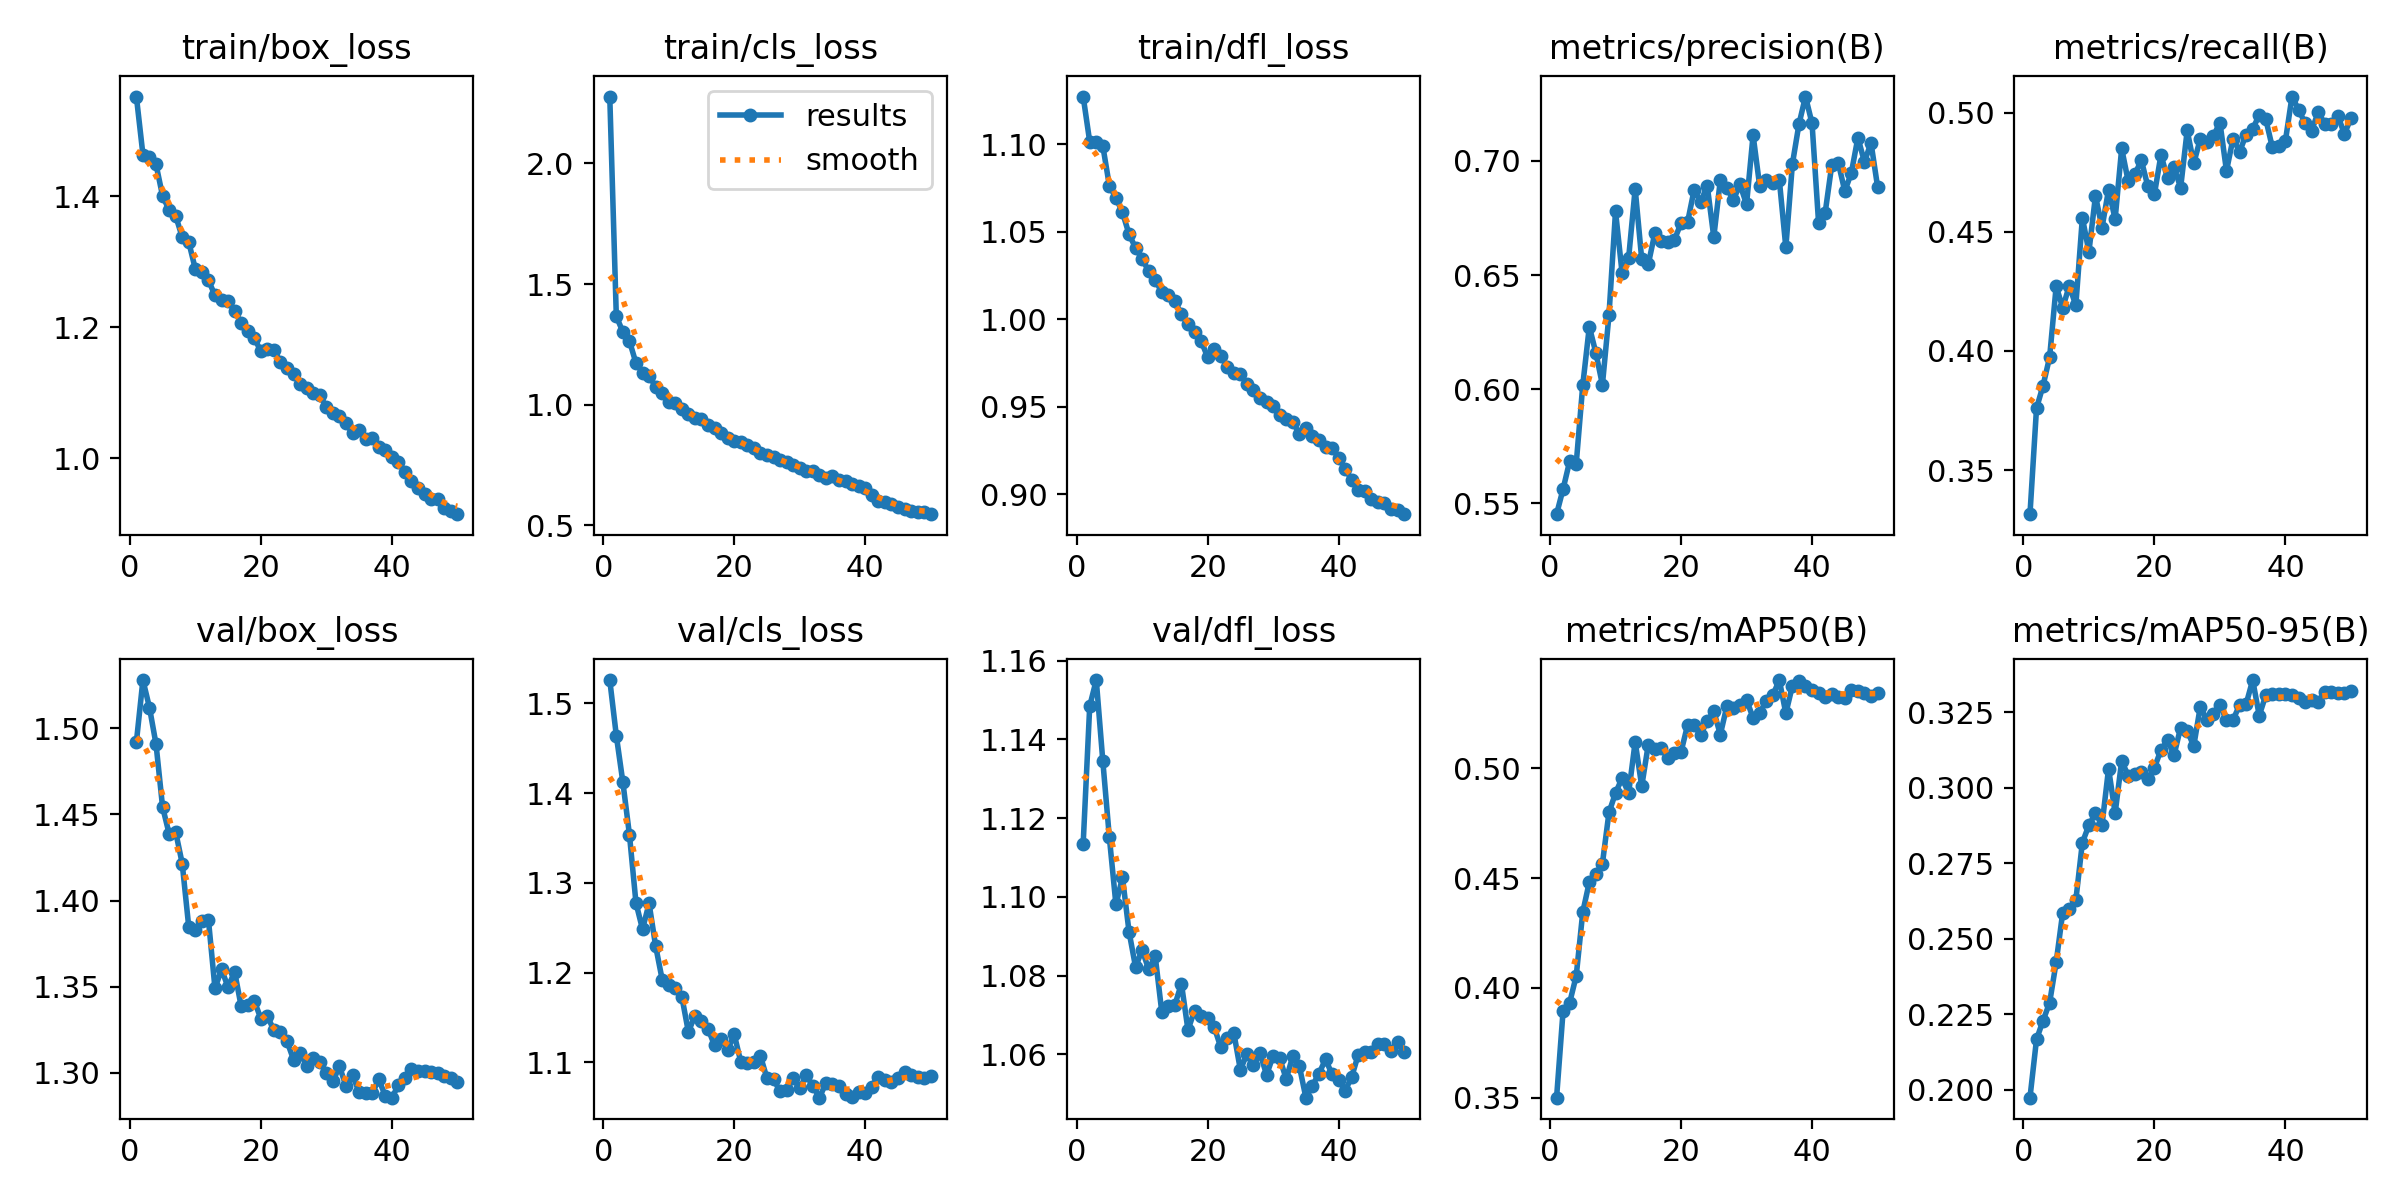

Confusion matrix:


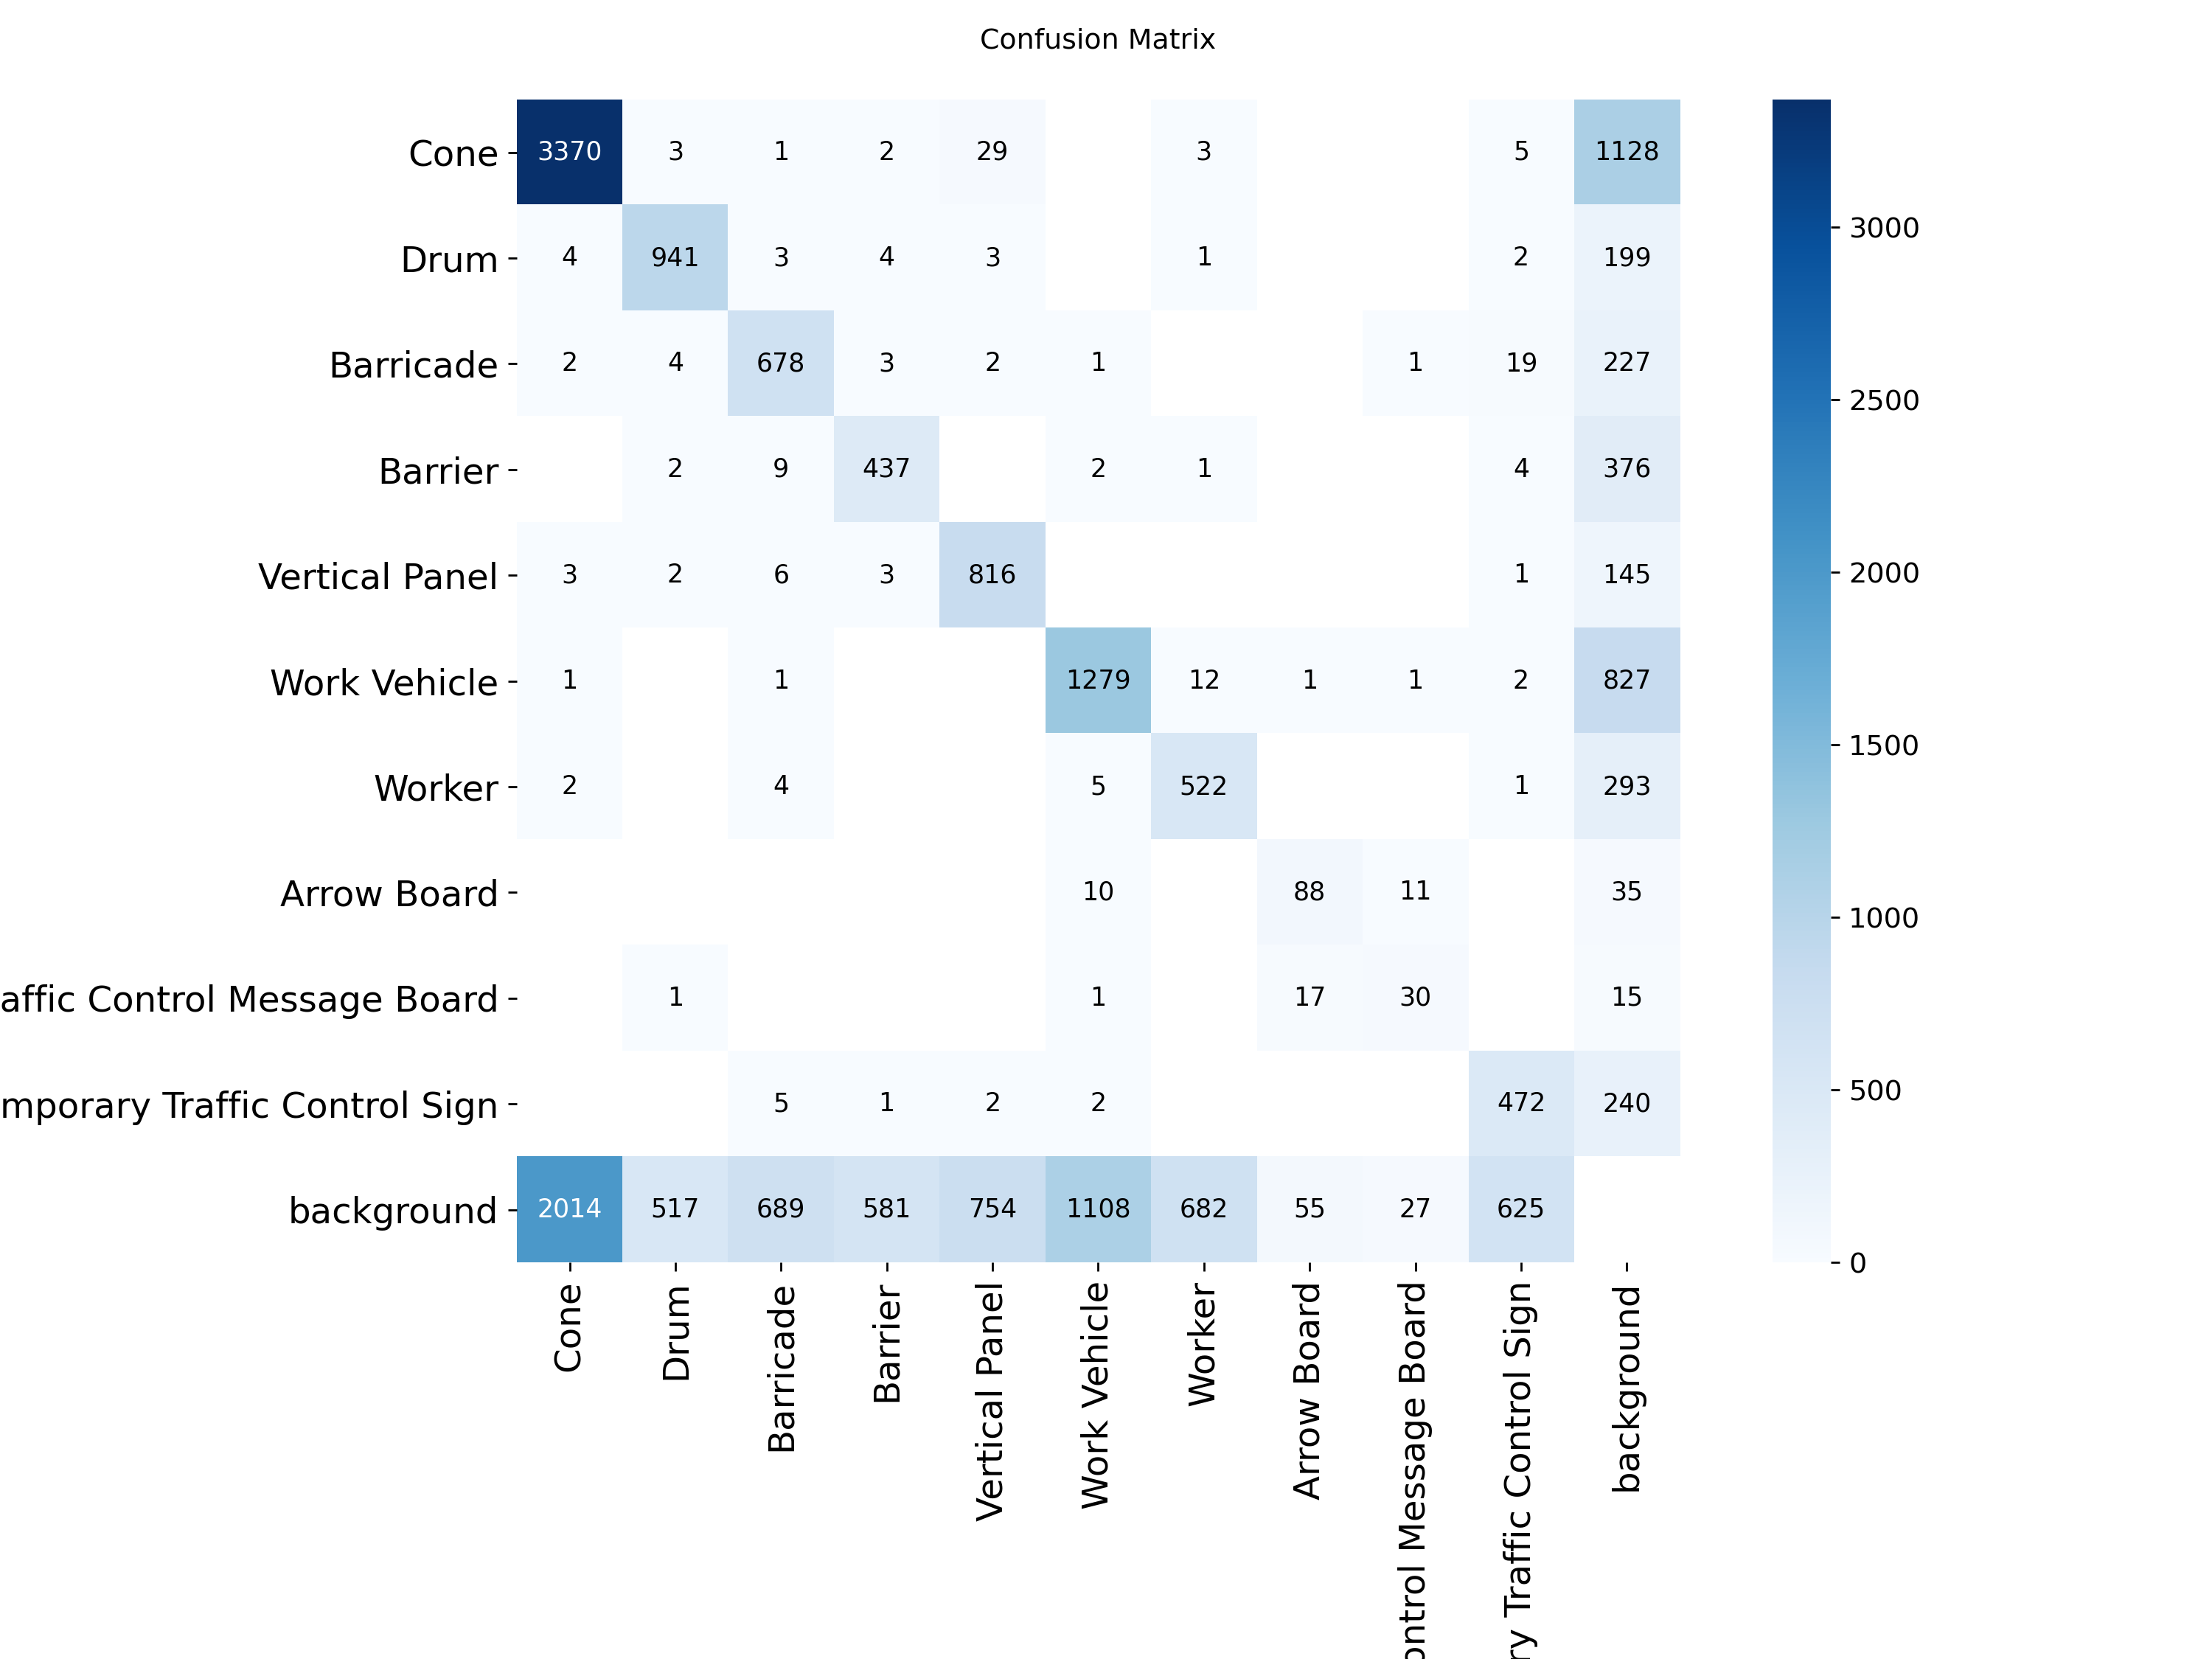

In [6]:
from IPython.display import Image, display

results_png = run_dir / "results.png"
cm_png = run_dir / "confusion_matrix.png"

print("results.png exists:", results_png.exists())
print("confusion_matrix.png exists:", cm_png.exists())

if results_png.exists():
    print("Training curves:")
    display(Image(filename=str(results_png)))
else:
    print("results.png not found at:", results_png)

if cm_png.exists():
    print("Confusion matrix:")
    display(Image(filename=str(cm_png)))
else:
    print("confusion_matrix.png not found at:", cm_png)

## 5. Evaluation on validation split

We now run the YOLO `val` method on the validation set defined in `workzone_yolo.yaml`.

This will compute standard detection metrics such as:

- mAP at IoU 0.50
- mAP at IoU 0.50:0.95
- per class precision, recall, and AP

In [6]:
# %% Validate model on the validation set

metrics = model.val(
    data=str(DATA_YAML),
    imgsz=640,
    split="val",
    save_json=True,
    project="runs_workzone",
    name="yolov8s_workzone_val",
    exist_ok=True,
)

print("Metrics type:", type(metrics))
print(metrics)

Ultralytics 8.3.231  Python-3.11.14 torch-2.10.0.dev20251114+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti Laptop GPU, 12227MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 1229.9872.1 MB/s, size: 547.1 KB)
val: Scanning C:\Users\wesle\Music\workingzone\workzone_yolo\labels\val.cache... 2046 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2046/2046 1.2Mit/s 0.0s
val: C:\Users\wesle\Music\workingzone\workzone_yolo\images\val\houston_1313e092c4d94bdf8349c99f763354b4_000000_07230.jpg: 14 duplicate labels removed
val: C:\Users\wesle\Music\workingzone\workzone_yolo\images\val\houston_1313e092c4d94bdf8349c99f763354b4_000000_07410.jpg: 13 duplicate labels removed
val: C:\Users\wesle\Music\workingzone\workzone_yolo\images\val\houston_1313e092c4d94bdf8349c99f763354b4_000000_08220.jpg: 9 duplicate labels removed
val: C:\Users\wesle\Music\workingzone\workzone_yolo\images\val\houston_1313e092c4d94bdf8349c99f763354

## 6. Inference speed measurement (FPS)

To get a sense of whether the model is usable in real time, we measure approximate inference speed on a few validation images.

This is a simple check, not a perfect benchmark, but it gives a rough FPS number for your current hardware.

In [7]:
# %% Simple FPS test on a few validation images

from glob import glob
import numpy as np
import cv2

# collect some validation images
val_img_dir = YOLO_ROOT / "images" / "val"
val_images = glob(str(val_img_dir / "*.jpg"))

print("Number of val images:", len(val_images))
test_images = val_images[:50] if len(val_images) > 50 else val_images

# warm up
for img_path in test_images[:5]:
    _ = model.predict(
        source=img_path,
        imgsz=640,
        verbose=False,
        device=0 if torch.cuda.is_available() else "cpu",
    )

# timed run
num_runs = len(test_images)
start = time.time()

for img_path in test_images:
    _ = model.predict(
        source=img_path,
        imgsz=640,
        verbose=False,
        device=0 if torch.cuda.is_available() else "cpu",
    )

end = time.time()
elapsed = end - start
fps = num_runs / elapsed if elapsed > 0 else 0

print(f"Inference on {num_runs} images took {elapsed:.2f} seconds")
print(f"Approximate FPS on single images: {fps:.1f}")


Number of val images: 2046
Inference on 50 images took 1.97 seconds
Approximate FPS on single images: 25.4


## 7. Qualitative check on a few images

We now run the model on a small sample of validation images and visualize the detections.

This helps us see whether the model is detecting cones, drums, barriers, workers, and TTC signs as expected.

In [15]:
# %% Run prediction on a few validation images and save previews

from glob import glob

val_img_dir = YOLO_ROOT / "images" / "val"
val_images = glob(str(val_img_dir / "*.jpg"))
sample_imgs = val_images[:5]

results = model.predict(
    source=sample_imgs,
    imgsz=640,
    save=True,
    project="runs_workzone",
    name="yolov8s_workzone_preview",
    exist_ok=True,
    device=0 if torch.cuda.is_available() else "cpu",
)

# Ultralytics stores the save directory in the results object
from pathlib import Path
preview_dir = Path(results[0].save_dir)
print("Preview directory:", preview_dir.resolve())
print("Exists:", preview_dir.exists())

Results saved to C:\Users\wesle\Music\workingzone\runs_workzone\yolov8s_workzone_preview
Preview directory: C:\Users\wesle\Music\workingzone\runs_workzone\yolov8s_workzone_preview
Exists: True


Preview files: ['boston_042e1caf93114d3286c11ba14ddaa759_000000_07800.jpg', 'boston_042e1caf93114d3286c11ba14ddaa759_000000_09000.jpg', 'boston_042e1caf93114d3286c11ba14ddaa759_000000_23610.jpg', 'boston_042e1caf93114d3286c11ba14ddaa759_000000_23760.jpg', 'boston_042e1caf93114d3286c11ba14ddaa759_000001_00180.jpg']


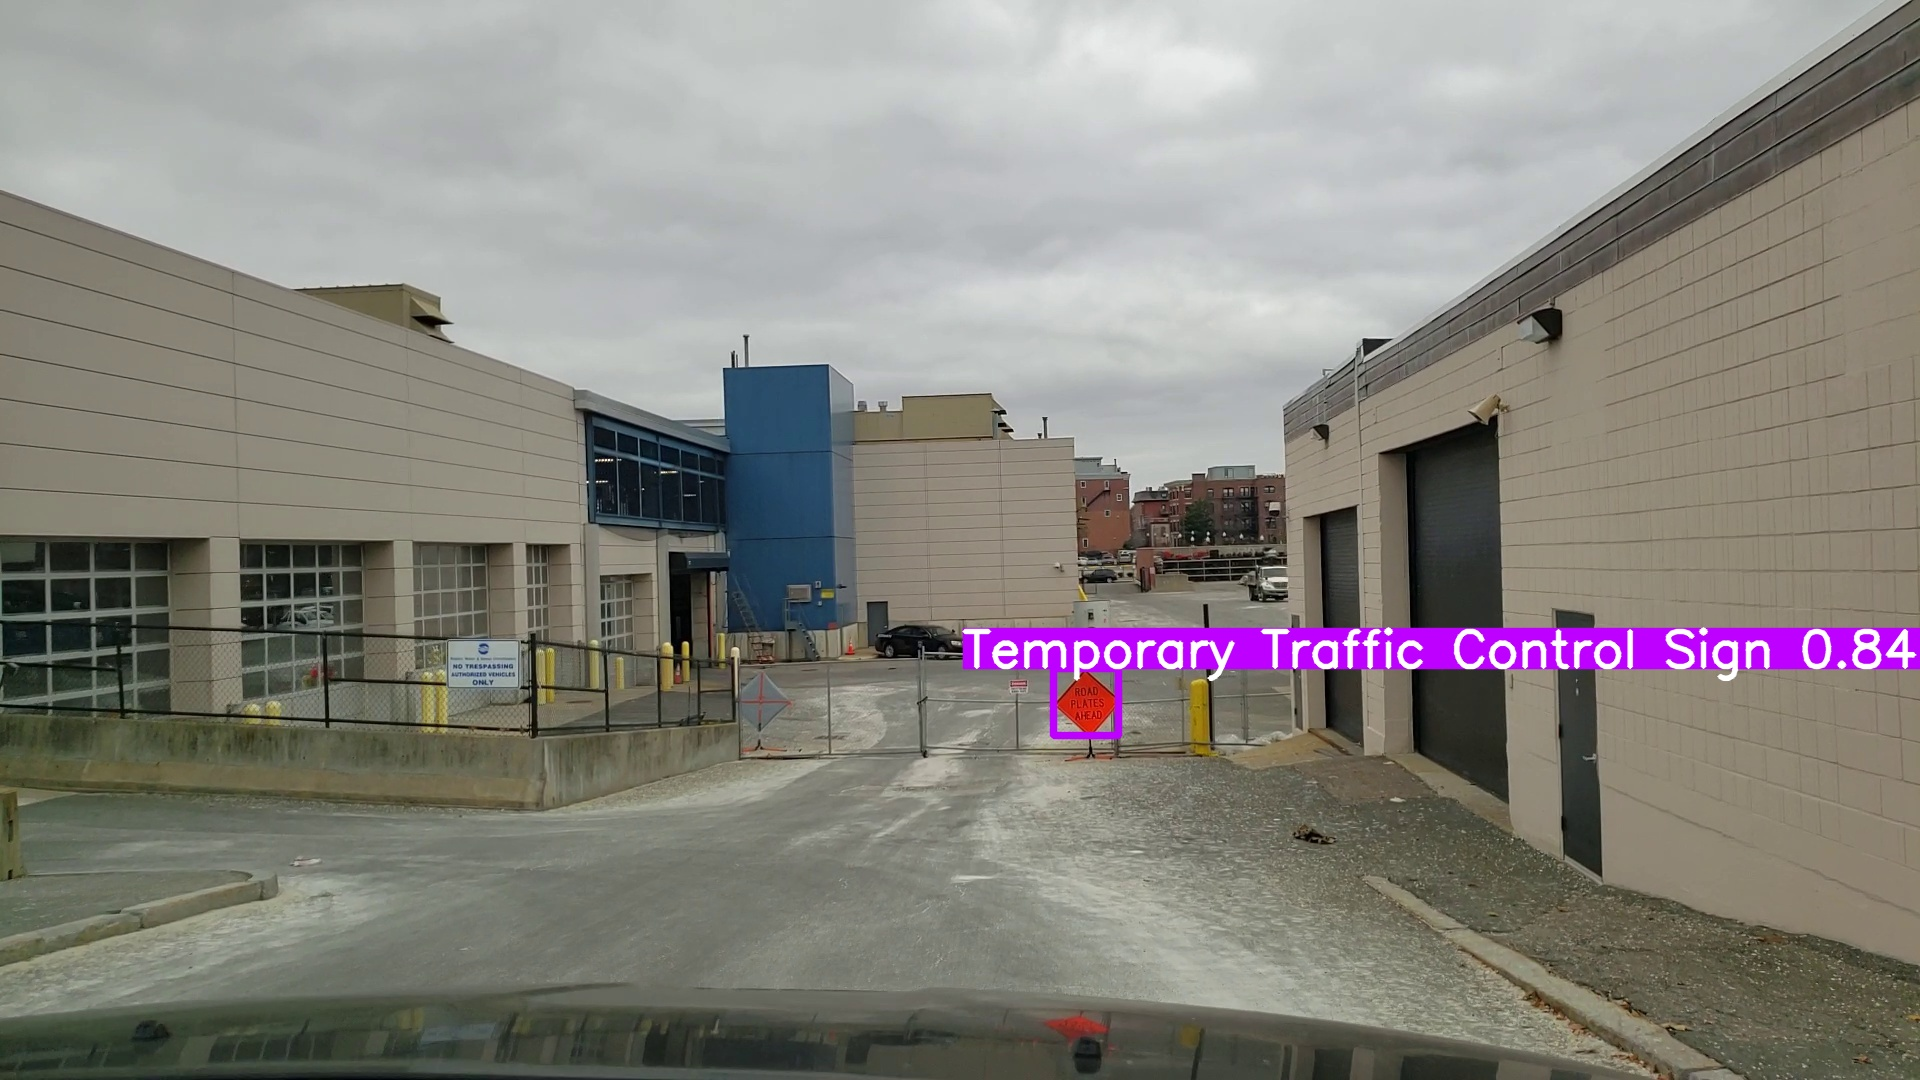

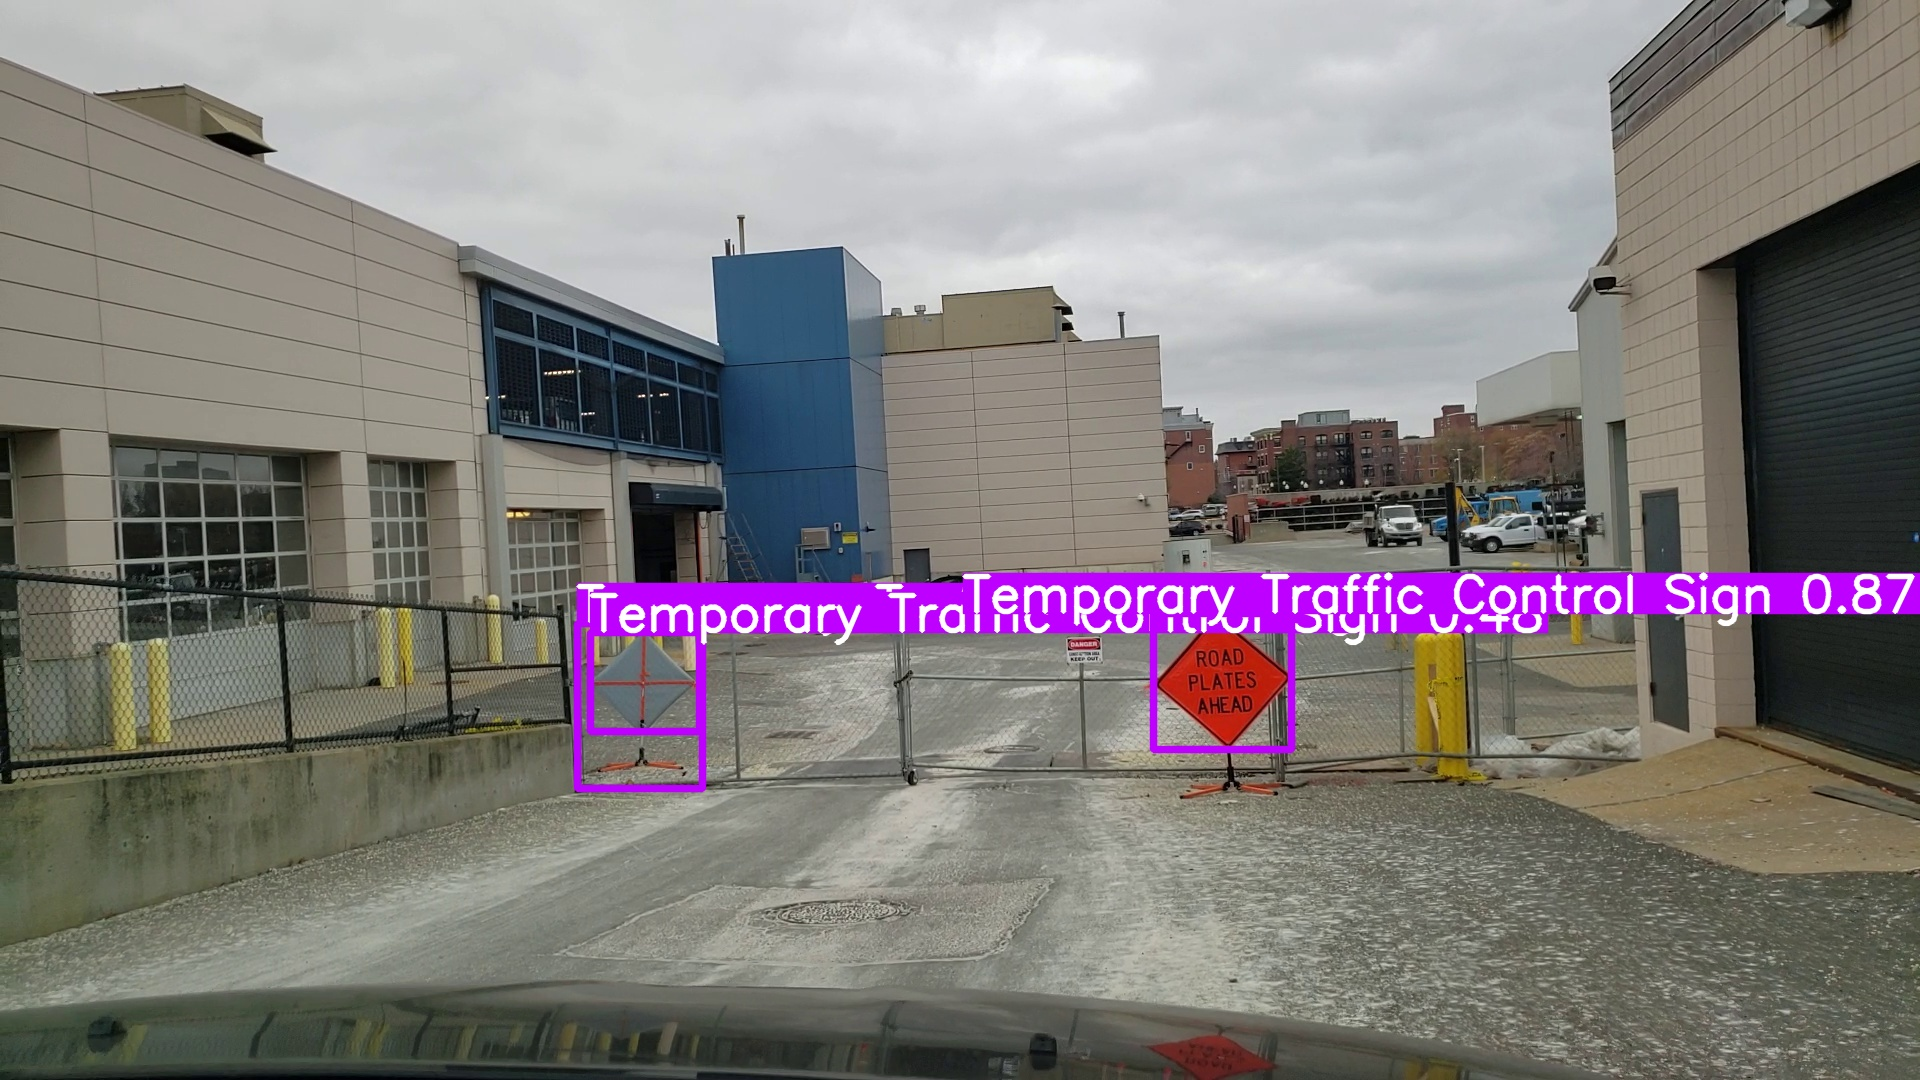

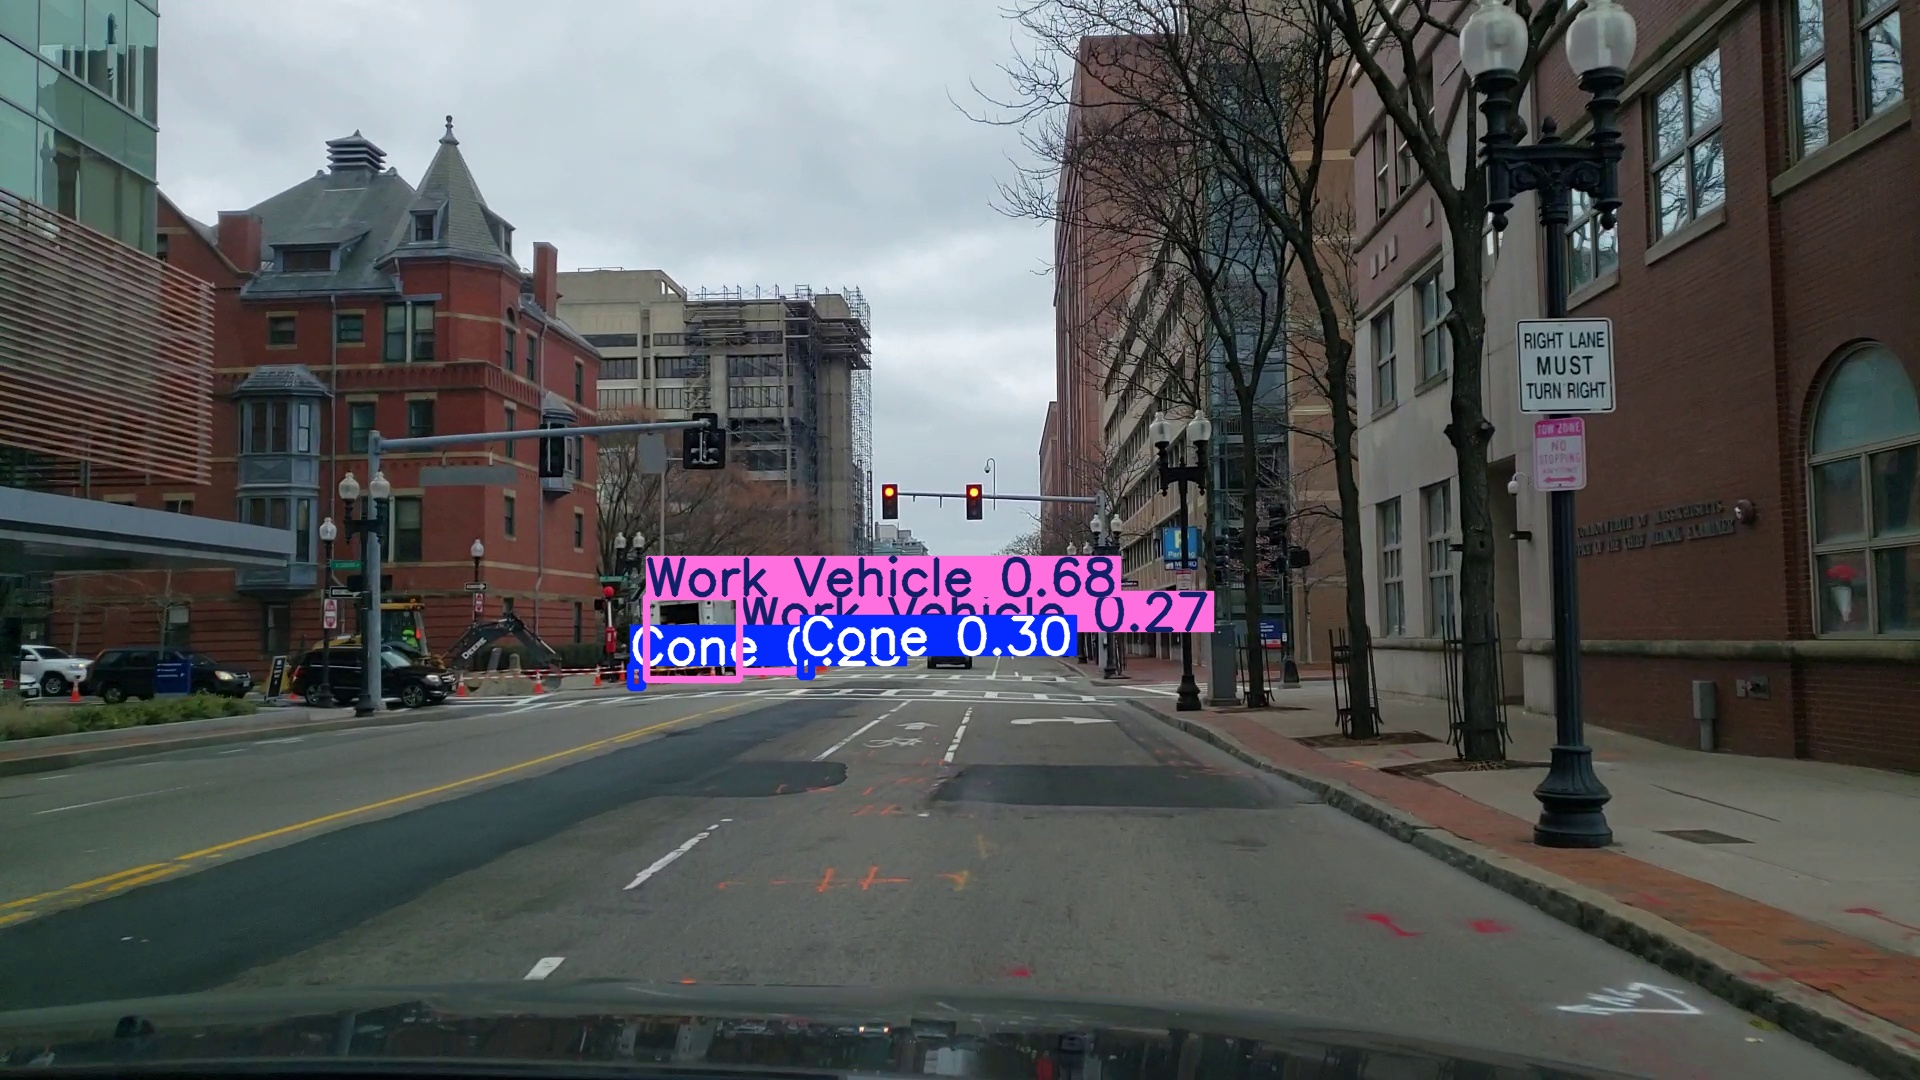

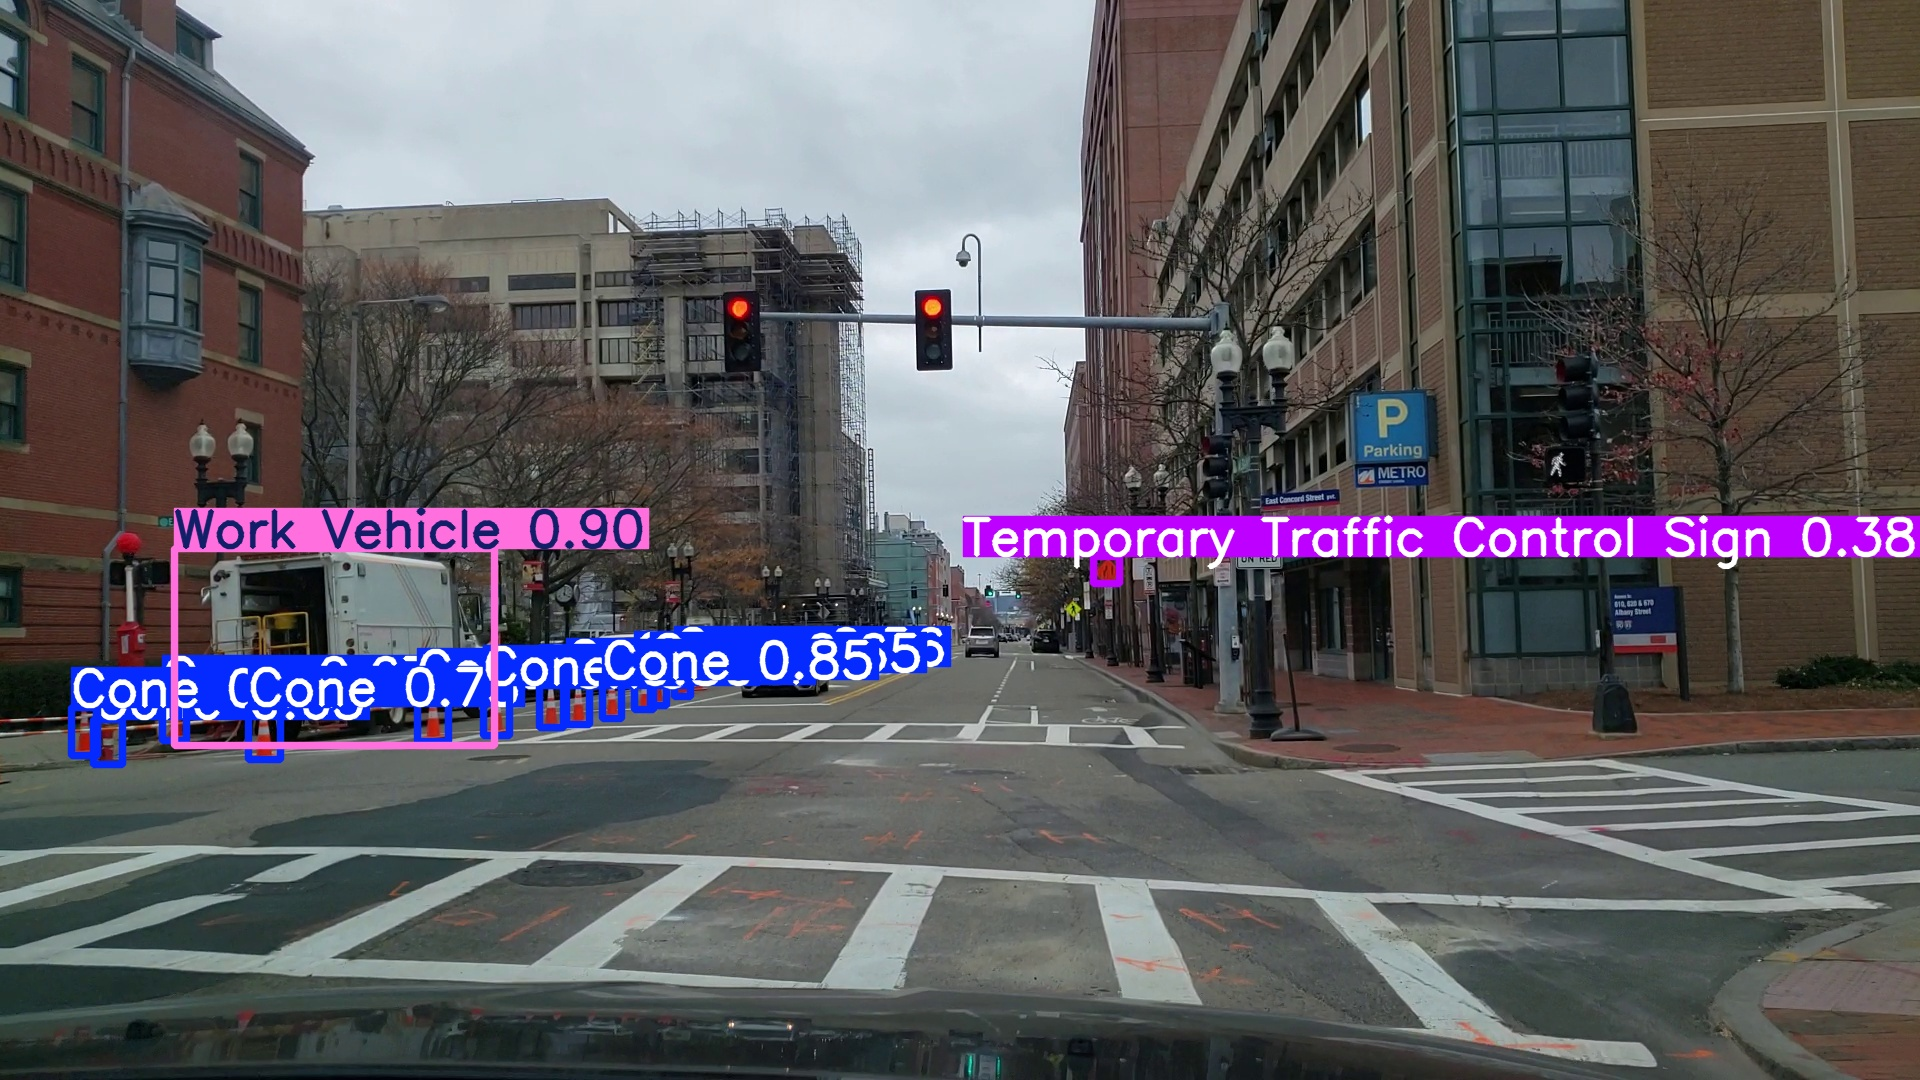

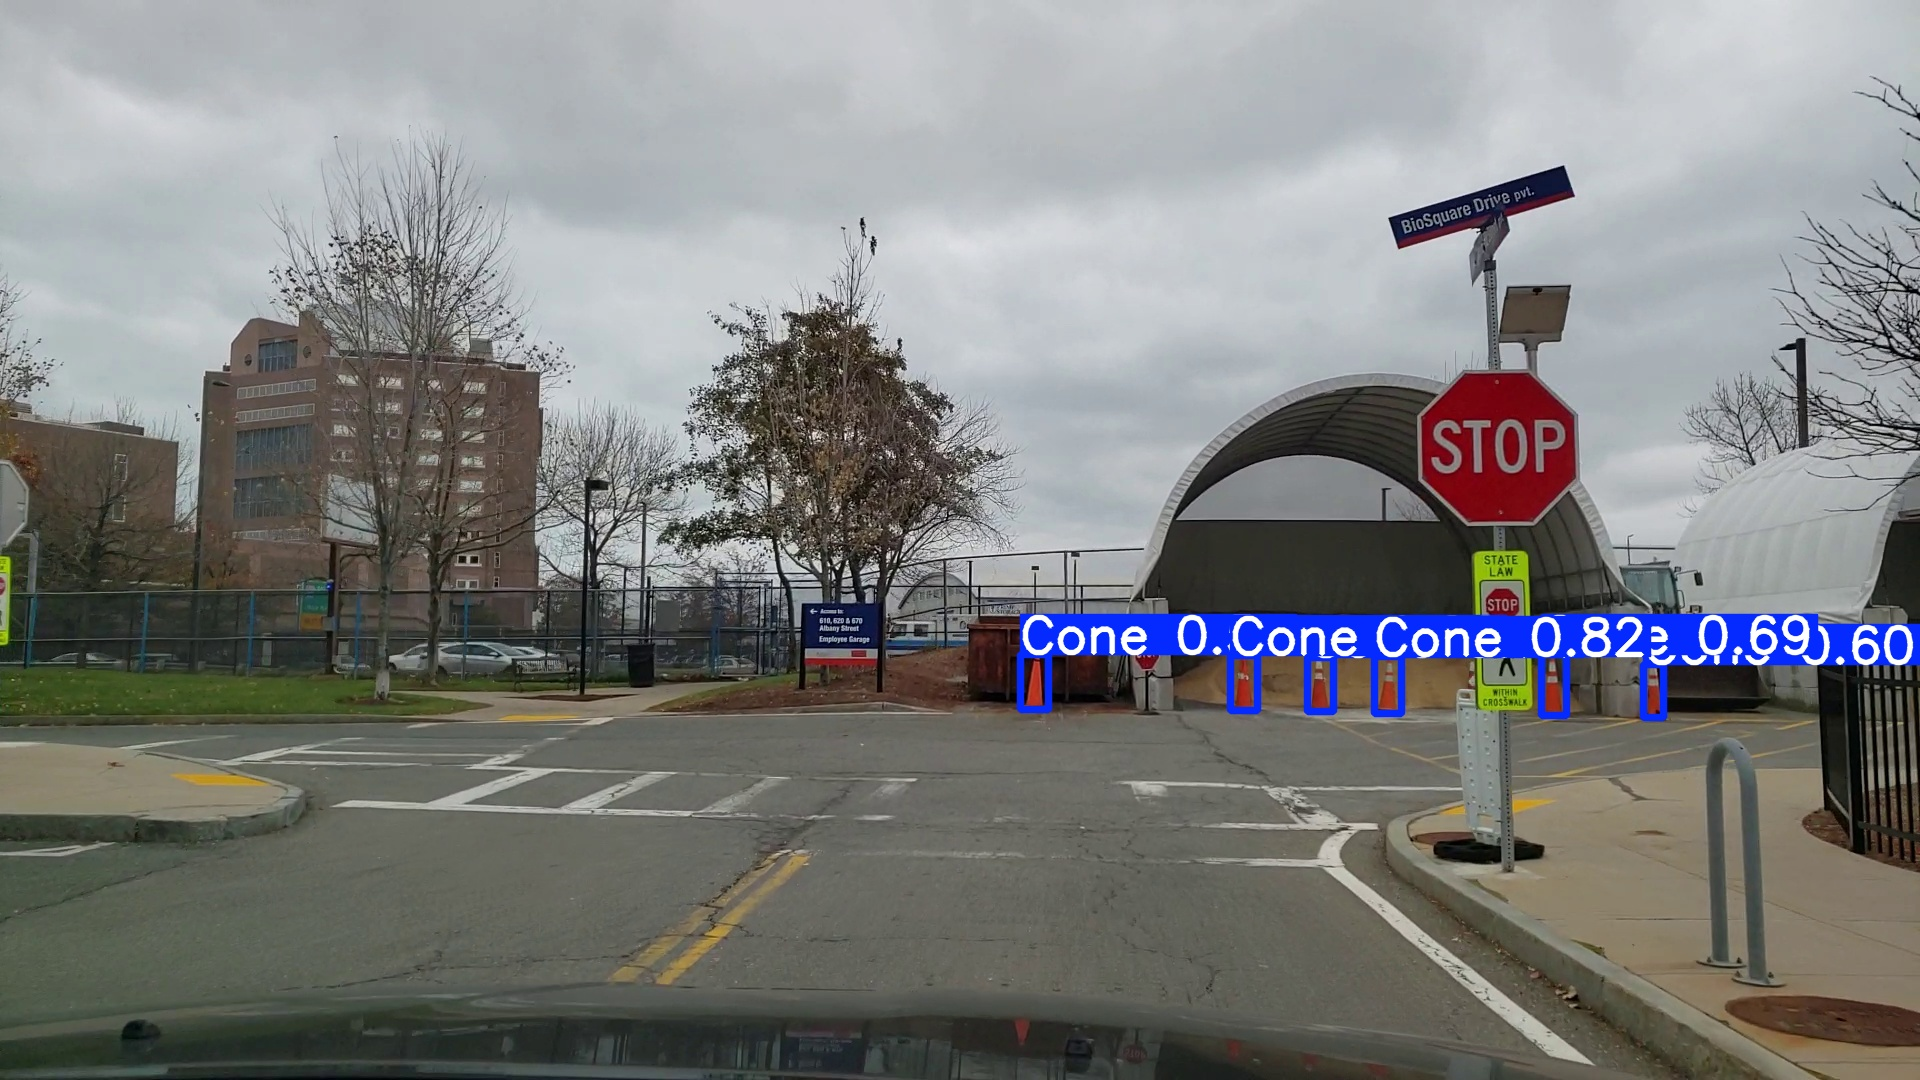

In [14]:
from IPython.display import Image as IPyImage, display

if preview_dir.exists():
    files = sorted(preview_dir.iterdir())
    print("Preview files:", [p.name for p in files[:5]])
    for p in files[:5]:
        display(IPyImage(filename=str(p)))
else:
    print("Preview directory does not exist. Check the predict cell above.")

## 8. Summary and next steps

At this point we have:

- Trained a YOLO detector on ROADWork based work zone classes.
- Verified that training completed and inspected curves and confusion matrix.
- Evaluated the model on the validation split to see mAP.
- Measured approximate FPS for single image inference.
- Visualized detections on a few validation images.

Next steps:

1. Use the trained `best.pt` in a separate notebook to build a video demo on recorded driving footage.
2. Design a work zone score on top of the detections to classify frames as work zone or no work zone.
3. Later, integrate further reasoning such as lane closure types and temporary speed limit handling.
